In [740]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [1]:
import requests
from bs4 import BeautifulSoup
from scrapy.selector import Selector

Start by scraping IMDB TV show IDs. I decided to focus on shows from 2013 to present, focusing on modern successes. I subset IMDB by using their advanced search and used the following criteria: 
    - Year after 2013
    - Reviews greater than 2500
    - Country of Origin United States
    
This subset left 410 show titles (on 9 pages) to be scraped below. 

First, just to demonstrate, here is the first page of IDs. 50 in total. 

In [24]:
URL = "http://www.imdb.com/search/title?countries=us&languages=%C2%B7%C2%B7%C2%B7%C2%A0Common%20Languages%C2%A0%C2%B7%C2%B7%C2%B7&num_votes=2500,&release_date=2013-01-01,&sort=user_rating,desc&title_type=tv_series&view=simple&page=1&ref_=adv_nxt"
r = requests.get(URL)
HTML = r.text

In [25]:
tv_shows_exmp = Selector(text=HTML).xpath('''//span[2]/a/@href''').extract()

In [26]:
tv_shows_exmp = [i.split('/') for i in tv_shows_exmp]
tv_shows_exmp = [i[2] for i in tv_shows_exmp]

In [27]:
print len(tv_shows_exmp)
tv_shows_exmp

50


[u'tt2861424',
 u'tt2356777',
 u'tt3530232',
 u'tt0475784',
 u'tt1856010',
 u'tt2802850',
 u'tt4574334',
 u'tt2707408',
 u'tt2782710',
 u'tt4786824',
 u'tt5555260',
 u'tt5712554',
 u'tt2297757',
 u'tt5834204',
 u'tt4093826',
 u'tt3032476',
 u'tt3322312',
 u'tt5034326',
 u'tt5189670',
 u'tt5425186',
 u'tt4295140',
 u'tt5071412',
 u'tt4158110',
 u'tt2575988',
 u'tt2243973',
 u'tt4288182',
 u'tt1984119',
 u'tt2874692',
 u'tt1837492',
 u'tt3006802',
 u'tt6315640',
 u'tt5114356',
 u'tt3673794',
 u'tt2788432',
 u'tt5853176',
 u'tt5673782',
 u'tt5863126',
 u'tt2937900',
 u'tt1734135',
 u'tt2919910',
 u'tt2431438',
 u'tt4270492',
 u'tt5580664',
 u'tt2017109',
 u'tt3398228',
 u'tt3061046',
 u'tt2578560',
 u'tt3655448',
 u'tt2183404',
 u'tt4592410']

Now we need to loop through the 9 pages. 

In [28]:
tv_shows = []
for i in range(1,10):
    tv_temp = []
    URL = "http://www.imdb.com/search/title?countries=us&languages=%C2%B7%C2%B7%C2%B7%C2%A0Common%20Languages%C2%A0%C2%B7%C2%B7%C2%B7&num_votes=2500,&release_date=2013-01-01,&sort=user_rating,desc&title_type=tv_series&view=simple&page={}&ref_=adv_nxt".format(i)
    r = requests.get(URL)
    HTML = r.text
    tv_temp = Selector(text=HTML).xpath('''//span[2]/a/@href''').extract()
    tv_temp = [i.split('/') for i in tv_temp]
    tv_temp = [i[2] for i in tv_temp]
    tv_shows.extend(tv_temp)

In [32]:
len(tv_shows)

410

We now have the ID for all 410 shows in my search. Now using the TVMaze Api we will pull more info about the shows.

In [33]:
import json

In [34]:
name = []
rating = []
genre = []
network =[]
premiere = []
status = []
summary = []
for i in tv_shows:
    res = requests.get('http://api.tvmaze.com/lookup/shows?imdb={}'.format(i))
    try :
        name.append(json.loads(res.text).get('name'))
    except :
        name.append(str(i) + ' not found')
    try :
        rating.append(json.loads(res.text).get('rating')['average'])
    except :
        rating.append(str(i) + ' not found')
    try :
        genre.append(json.loads(res.text).get('genres'))
    except :
        genre.append(str(i) + ' not found')
    try :
        network.append(json.loads(res.text).get('network')['name'])
    except :
        network.append(str(i) + ' not found')
    try :
        premiere.append(json.loads(res.text).get('premiered'))
    except :
        premiere.append(str(i) + ' not found')
    try :
        status.append(json.loads(res.text).get('status'))
    except :
        status.append(str(i) + ' not found')
    try :
        summary.append(json.loads(res.text).get('summary'))
    except :
        summary.append(str(i) + ' not found')

In [2]:
import pandas as pd

For some of the other TVMaze Apis it will be helpful to have the TVMaze ID.

In [ ]:
a = pd.DataFrame([name, rating, genre, network, premiere, status, summary]).T
a.columns = ['name', 'rating', 'genre', 'network', 'premiere', 'status', 'summary'].head

In [62]:
tv_maze_id = []
for i in tv_shows:
    res = requests.get('http://api.tvmaze.com/lookup/shows?imdb={}'.format(i))
    try :
        tv_maze_id.append(json.loads(res.text).get('id'))
    except :
        tv_maze_id.append(str(i) + ' not found')

In [66]:
a['tv_maze_id'] = tv_maze_id

In [102]:
runtime = []
for i in tv_shows:
    res = requests.get('http://api.tvmaze.com/lookup/shows?imdb={}'.format(i))
    try :
        runtime.append(json.loads(res.text).get('runtime'))
    except :
        runtime.append(str(i) + ' not found')

In [103]:
a['runtime'] = runtime

In [104]:
a[a['name'].str.contains("not found")].count()

name          21
rating        21
genre         21
network       21
premiere      21
status        21
summary       21
tv_maze_id    21
cast          21
runtime       21
dtype: int64

In [89]:
casts = []
for i in tv_maze_id:
    cast = requests.get('http://api.tvmaze.com/shows/{}/cast'.format(i))
    show_cast = []
    for j in range(0,len(json.loads(cast.text))):
        try :
            show_cast.append(json.loads(cast.text)[j].get('person')['name'])
        except :
            show_cast.append(str(i) + ' not found')
    casts.append(show_cast)

In [90]:
casts

[[u'Justin Roiland',
  u'Spencer Grammer',
  u'Sarah Chalke',
  u'Justin Roiland',
  u'Chris Parnell'],
 [u'Tory Kittles',
  u'Matthew McConaughey',
  u'Woody Harrelson',
  u'Rachel McAdams',
  u'Kelly Reilly',
  u'Michelle Monaghan',
  u'Michael Potts',
  u'Colin Farrell',
  u'Vince Vaughn',
  u'Taylor Kitsch'],
 [u'John Oliver'],
 [u'Anthony Hopkins',
  u'Jeffrey Wright',
  u'Thandie Newton',
  u'Ed Harris',
  u'Evan Rachel Wood',
  u'James Marsden',
  u'Shannon Marie Woodward',
  u'Angela Sarafyan',
  u'Sidse Babett Knudsen',
  u'Jimmi Simpson',
  u'Luke Hemsworth',
  u'Ben Barnes',
  u'Ingrid Bols\xf8 Berdal',
  u'Rodrigo Santoro',
  u'Tessa Thompson',
  u'Clifton Collins, Jr.',
  u'Simon Quarterman',
  u'Jeffrey Wright',
  u'Katja Herbers'],
 [u'Kevin Spacey',
  u'Robin Wright',
  u'Michael Kelly',
  u'Derek Cecil',
  u'Nathan Darrow',
  u'Jayne Atkinson',
  u'Mahershala Ali',
  u'Paul Sparks',
  u'Molly Parker',
  u'Neve Campbell',
  u'Boris McGiver',
  u'Michel Gill',
  u'Larry 

In [91]:
a['cast'] = casts

In [107]:
a.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,cast,runtime
0,Rick and Morty,9.4,"[Comedy, Adventure, Science-Fiction]",Adult Swim,2013-12-02,Running,"<p>Rick is a mentally gifted, but sociopathic ...",216,"[Justin Roiland, Spencer Grammer, Sarah Chalke...",30
1,True Detective,8.5,"[Drama, Crime, Thriller, Mystery]",HBO,2014-01-12,Running,<p>The series stars Matthew McConaughey and Wo...,5,"[Tory Kittles, Matthew McConaughey, Woody Harr...",60
2,Last Week Tonight with John Oliver,9.2,[Comedy],HBO,2014-04-27,Running,<p>On <b>Last Week Tonight with John Oliver</b...,263,[John Oliver],30
3,Westworld,8.9,"[Drama, Science-Fiction, Western]",HBO,2016-10-02,Running,<p>The one-hour drama series <b>Westworld</b> ...,1371,"[Anthony Hopkins, Jeffrey Wright, Thandie Newt...",60
4,House of Cards,8.7,"[Drama, Thriller]",tt1856010 not found,2013-02-01,To Be Determined,<p>Based on the BBC miniseries of the same nam...,175,"[Kevin Spacey, Robin Wright, Michael Kelly, De...",60


In [113]:
episode_count = []
for i in tv_maze_id:
    seasons = requests.get('http://api.tvmaze.com/shows/{}/seasons'.format(i))
    episode_order = []
    for j in range(0,len(json.loads(seasons.text))):
        try :
            episode_order.append(json.loads(seasons.text)[j].get('episodeOrder'))
        except :
            episode_order.append(str(i) + ' not found')
    episode_count.append(episode_order)

In [128]:
a['episode_count'] = episode_count

In [147]:
a.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,cast,runtime,episode_count
0,Rick and Morty,9.4,"[Comedy, Adventure, Science-Fiction]",Adult Swim,2013-12-02,Running,"<p>Rick is a mentally gifted, but sociopathic ...",216,"[Justin Roiland, Spencer Grammer, Sarah Chalke...",30,"[11, 10, 10]"
1,True Detective,8.5,"[Drama, Crime, Thriller, Mystery]",HBO,2014-01-12,Running,<p>The series stars Matthew McConaughey and Wo...,5,"[Tory Kittles, Matthew McConaughey, Woody Harr...",60,"[8, 8]"
2,Last Week Tonight with John Oliver,9.2,[Comedy],HBO,2014-04-27,Running,<p>On <b>Last Week Tonight with John Oliver</b...,263,[John Oliver],30,"[None, None, 30, None]"
3,Westworld,8.9,"[Drama, Science-Fiction, Western]",HBO,2016-10-02,Running,<p>The one-hour drama series <b>Westworld</b> ...,1371,"[Anthony Hopkins, Jeffrey Wright, Thandie Newt...",60,"[10, None]"
4,House of Cards,8.7,"[Drama, Thriller]",tt1856010 not found,2013-02-01,To Be Determined,<p>Based on the BBC miniseries of the same nam...,175,"[Kevin Spacey, Robin Wright, Michael Kelly, De...",60,"[None, None, 13, 13, 13]"


In [152]:
import matplotlib.pyplot as plt

In [158]:
crews = []
for i in tv_maze_id:
    crew = requests.get('http://api.tvmaze.com/shows/{}/crew'.format(i))
    show_crew = []
    for j in range(0,len(json.loads(crew.text))):
        try :
            show_crew.append(json.loads(crew.text)[j].get('person')['name'])
        except :
            show_crew.append(str(i) + ' not found')
    crews.append(show_crew)

In [162]:
crews = [list(set(i)) for i in crews]

In [163]:
a['crew'] = crews

In [164]:
a.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,cast,runtime,episode_count,crew
0,Rick and Morty,9.4,"[Comedy, Adventure, Science-Fiction]",Adult Swim,2013-12-02,Running,"<p>Rick is a mentally gifted, but sociopathic ...",216,"[Justin Roiland, Spencer Grammer, Sarah Chalke...",30,"[11, 10, 10]","[Joe Russo II, Dan Guterman, Ryan Ridley, Tom ..."
1,True Detective,8.5,"[Drama, Crime, Thriller, Mystery]",HBO,2014-01-12,Running,<p>The series stars Matthew McConaughey and Wo...,5,"[Tory Kittles, Matthew McConaughey, Woody Harr...",60,"[8, 8]","[Matthew McConaughey, Scott Stephens, Nic Pizz..."
2,Last Week Tonight with John Oliver,9.2,[Comedy],HBO,2014-04-27,Running,<p>On <b>Last Week Tonight with John Oliver</b...,263,[John Oliver],30,"[None, None, 30, None]","[Tim Carvell, Jon Thoday]"
3,Westworld,8.9,"[Drama, Science-Fiction, Western]",HBO,2016-10-02,Running,<p>The one-hour drama series <b>Westworld</b> ...,1371,"[Anthony Hopkins, Jeffrey Wright, Thandie Newt...",60,"[10, None]","[David Coatsworth, Katherine Lingenfelter, Rob..."
4,House of Cards,8.7,"[Drama, Thriller]",tt1856010 not found,2013-02-01,To Be Determined,<p>Based on the BBC miniseries of the same nam...,175,"[Kevin Spacey, Robin Wright, Michael Kelly, De...",60,"[None, None, 13, 13, 13]","[Johanna Argan, Karen Moore, Kirk Baxter, Aima..."


In [193]:
show_type = []
for i in tv_shows:
    res = requests.get('http://api.tvmaze.com/lookup/shows?imdb={}'.format(i))
    try :
        show_type.append(json.loads(res.text).get('type'))
    except :
        show_type.append(str(i) + ' not found')

In [195]:
a['show_type'] = show_type

In [197]:
a.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,cast,runtime,episode_count,crew,show_type
0,Rick and Morty,9.4,"[Comedy, Adventure, Science-Fiction]",Adult Swim,2013-12-02,Running,"<p>Rick is a mentally gifted, but sociopathic ...",216,"[Justin Roiland, Spencer Grammer, Sarah Chalke...",30,"[11, 10, 10]","[Joe Russo II, Dan Guterman, Ryan Ridley, Tom ...",Animation
1,True Detective,8.5,"[Drama, Crime, Thriller, Mystery]",HBO,2014-01-12,Running,<p>The series stars Matthew McConaughey and Wo...,5,"[Tory Kittles, Matthew McConaughey, Woody Harr...",60,"[8, 8]","[Matthew McConaughey, Scott Stephens, Nic Pizz...",Scripted
2,Last Week Tonight with John Oliver,9.2,[Comedy],HBO,2014-04-27,Running,<p>On <b>Last Week Tonight with John Oliver</b...,263,[John Oliver],30,"[None, None, 30, None]","[Tim Carvell, Jon Thoday]",Talk Show
3,Westworld,8.9,"[Drama, Science-Fiction, Western]",HBO,2016-10-02,Running,<p>The one-hour drama series <b>Westworld</b> ...,1371,"[Anthony Hopkins, Jeffrey Wright, Thandie Newt...",60,"[10, None]","[David Coatsworth, Katherine Lingenfelter, Rob...",Scripted
4,House of Cards,8.7,"[Drama, Thriller]",tt1856010 not found,2013-02-01,To Be Determined,<p>Based on the BBC miniseries of the same nam...,175,"[Kevin Spacey, Robin Wright, Michael Kelly, De...",60,"[None, None, 13, 13, 13]","[Johanna Argan, Karen Moore, Kirk Baxter, Aima...",Scripted


In [223]:
a.shape

(410, 13)

In [190]:
for i in range(0,len(a[a['name'].str.contains("not found")]['name'])):
    print a[a['name'].str.contains("not found")]['name'].values[i][:10]

tt4093826 
tt5071412 
tt2919910 
tt5011816 
tt4687880 
tt4658330 
tt4687892 
tt5770786 
tt5028002 
tt4118466 
tt5540054 
tt5503718 
tt4820370 
tt2944454 
tt5565334 
tt5707802 
tt5083928 
tt5467814 
tt5639976 
tt2621446 
tt6021260 


Above are the 21 shows not found. I manually search for their tv maze id. The first show is the Twin Peaks revival. The remake has it's own IMDB page but not Tv Maze page so it will be ignored. Similar for Whose Line Is It Anyway (3rd ID). "Three's A Pain" was still not found (6th ID). A handful of others also either weren't found or didnt make sense.

In [192]:
tv_maze_id_nf = [13417, 2686,3039,2518,17869,12323,8798,14116,11266,8706,20345,16790,2793,11821,3728,20655]

In [198]:
name2 = []
rating2 = []
genre2 = []
network2 =[]
premiere2 = []
status2 = []
summary2 = []
for i in tv_maze_id_nf:
    res = requests.get('http://api.tvmaze.com/shows/{}'.format(i))
    try :
        name2.append(json.loads(res.text).get('name'))
    except :
        name2.append(str(i) + ' not found')
    try :
        rating2.append(json.loads(res.text).get('rating')['average'])
    except :
        rating2.append(str(i) + ' not found')
    try :
        genre2.append(json.loads(res.text).get('genres'))
    except :
        genre2.append(str(i) + ' not found')
    try :
        network2.append(json.loads(res.text).get('network')['name'])
    except :
        network2.append(str(i) + ' not found')
    try :
        premiere2.append(json.loads(res.text).get('premiered'))
    except :
        premiere2.append(str(i) + ' not found')
    try :
        status2.append(json.loads(res.text).get('status'))
    except :
        status2.append(str(i) + ' not found')
    try :
        summary2.append(json.loads(res.text).get('summary'))
    except :
        summary2.append(str(i) + ' not found')

In [199]:
b = pd.DataFrame([name2, rating2, genre2, network2, premiere2, status2, summary2]).T
b.columns = ['name', 'rating', 'genre', 'network', 'premiere', 'status', 'summary']

In [201]:
b

,name,rating,genre,network,premiere,status,summary
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st..."
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no..."
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...
5,StartUp,7.5,"[Drama, Crime, Thriller]",12323 not found,2016-09-06,Running,"<p>The 10-episode, one-hour original drama ser..."
6,Incorporated,7.1,"[Drama, Science-Fiction, Thriller]",Syfy,2016-11-30,Ended,<p>Set in a future where companies have seemin...
7,The Tick,7.3,"[Comedy, Action, Science-Fiction]",14116 not found,2016-08-19,Running,<p>In a world where superheroes and villains a...
8,Gypsy,6.1,[Drama],11266 not found,2017-06-30,Ended,<p>A thrilling new series follows Jean Hollowa...
9,Channel Zero,7.4,"[Drama, Horror, Supernatural]",Syfy,2016-10-11,Running,<p>Get ready for some thrills and chills with ...


In [202]:
b['tv_maze_id'] = tv_maze_id_nf

In [203]:
b.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st...",13417
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...,2686
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no...",3039
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...,2518
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...,17869


In [210]:
runtime2 = []
for i in tv_maze_id_nf:
    res = requests.get('http://api.tvmaze.com/shows/{}'.format(i))
    try :
        runtime2.append(json.loads(res.text).get('runtime'))
    except :
        runtime2.append(str(i) + ' not found')

In [211]:
b['runtime'] = runtime2
b.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,runtime
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st...",13417,60
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...,2686,48
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no...",3039,60
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...,2518,55
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...,17869,40


In [214]:
episode_count2 = []
for i in tv_maze_id_nf:
    seasons = requests.get('http://api.tvmaze.com/shows/{}/seasons'.format(i))
    episode_order2 = []
    for j in range(0,len(json.loads(seasons.text))):
        try :
            episode_order2.append(json.loads(seasons.text)[j].get('episodeOrder'))
        except :
            episode_order2.append(str(i) + ' not found')
    episode_count2.append(episode_order2)

In [215]:
b['episode_count'] = episode_count2
b.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,runtime,episode_count
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st...",13417,60,"[10, 10]"
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...,2686,48,"[10, 10]"
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no...",3039,60,"[8, None]"
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...,2518,55,[10]
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...,17869,40,"[10, None]"


In [216]:
crews2 = []
for i in tv_maze_id_nf:
    crew = requests.get('http://api.tvmaze.com/shows/{}/crew'.format(i))
    show_crew2 = []
    for j in range(0,len(json.loads(crew.text))):
        try :
            show_crew2.append(json.loads(crew.text)[j].get('person')['name'])
        except :
            show_crew2.append(str(i) + ' not found')
    crews2.append(show_crew2)

In [404]:
crews2 = [list(set(i)) for i in crews2]

In [405]:
b['crew'] = crews2
b.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,runtime,episode_count,crew,cast,show_type
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st...",13417,60,"[10, 10]","[Larry Benjamin, Gabe Hilfer, Matthew Spiegel,...","[Jason Butler Harner, Skylar Gaertner, Jason B...",Scripted
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...,2686,48,"[10, 10]","[Sharon Bialy, Laurence Bennett, Mark A. Baker...","[Libe Barer, Peter Gerety, Shane McRae, Giovan...",Scripted
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no...",3039,60,"[8, None]","[Camille H. Patton, Ross Fineman, Jennifer Lar...","[Sarah Wynter, Nina Arianda, Maria Bello, Moll...",Scripted
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...,2518,55,[10],"[Mark Bourgeois, Don Kurt, Gary Calamar, Scott...","[Genevieve Angelson, Hunter Parrish, Chris Dia...",Scripted
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...,17869,40,"[10, None]","[Rachel Shukert, John Kincade, Nick Jones, Tar...","[Britney Young, Betty Gilpin, Sydelle Noel, Al...",Scripted


In [220]:
casts2 = []
for i in tv_maze_id_nf:
    cast = requests.get('http://api.tvmaze.com/shows/{}/cast'.format(i))
    show_cast2 = []
    for j in range(0,len(json.loads(cast.text))):
        try :
            show_cast2.append(json.loads(cast.text)[j].get('person')['name'])
        except :
            show_cast2.append(str(i) + ' not found')
    casts2.append(show_cast2)

In [222]:
b['cast'] = casts2
b.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,runtime,episode_count,crew,cast
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st...",13417,60,"[10, 10]","[Chris Mundy, Ryan Farley, Jason Bateman, Juan...","[Jason Butler Harner, Skylar Gaertner, Jason B..."
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...,2686,48,"[10, 10]","[Michael Dinner, Seth Gordon, Mary Rohlich, Br...","[Libe Barer, Peter Gerety, Shane McRae, Giovan..."
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no...",3039,60,"[8, None]","[David Semel, Lawrence Trilling, Jonathan Shap...","[Sarah Wynter, Nina Arianda, Maria Bello, Moll..."
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...,2518,55,[10],"[Lynda Obst, Scott Winant, Darlene Hunt, Matt ...","[Genevieve Angelson, Hunter Parrish, Chris Dia..."
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...,17869,40,"[10, None]","[Jesse Peretz, Ashley Glazier, Liz Flahive, Li...","[Britney Young, Betty Gilpin, Sydelle Noel, Al..."


In [224]:
show_type2 = []
for i in tv_maze_id_nf:
    res = requests.get('http://api.tvmaze.com/shows/{}'.format(i))
    try :
        show_type2.append(json.loads(res.text).get('type'))
    except :
        show_type2.append(str(i) + ' not found')

In [225]:
b['show_type'] = show_type2
b.head()

,name,rating,genre,network,premiere,status,summary,tv_maze_id,runtime,episode_count,crew,cast,show_type
0,Ozark,8.1,[Drama],13417 not found,2017-07-21,Running,"<p>In this dark, dangerous series, a family st...",13417,60,"[10, 10]","[Chris Mundy, Ryan Farley, Jason Bateman, Juan...","[Jason Butler Harner, Skylar Gaertner, Jason B...",Scripted
1,Sneaky Pete,8,"[Drama, Crime]",2686 not found,2015-08-07,Running,<p><b>Sneaky Pete</b> centers on a thirty-some...,2686,48,"[10, 10]","[Michael Dinner, Seth Gordon, Mary Rohlich, Br...","[Libe Barer, Peter Gerety, Shane McRae, Giovan...",Scripted
2,Goliath,8.2,"[Drama, Crime, Legal]",3039 not found,2016-10-14,Running,"<p>Once a powerful lawyer, Billy McBride is no...",3039,60,"[8, None]","[David Semel, Lawrence Trilling, Jonathan Shap...","[Sarah Wynter, Nina Arianda, Maria Bello, Moll...",Scripted
3,Good Girls Revolt,8.6,[Drama],2518 not found,2015-11-05,Ended,<p>It was the 1960's - a time of economic boom...,2518,55,[10],"[Lynda Obst, Scott Winant, Darlene Hunt, Matt ...","[Genevieve Angelson, Hunter Parrish, Chris Dia...",Scripted
4,GLOW,8.1,"[Comedy, Action]",17869 not found,2017-06-23,Running,<p>Inspired by the real story of the 1980's fe...,17869,40,"[10, None]","[Jesse Peretz, Ashley Glazier, Liz Flahive, Li...","[Britney Young, Betty Gilpin, Sydelle Noel, Al...",Scripted


In [406]:
b.shape

(16, 13)

Now that I have info on additional 16 shows, I add those to the original dataframe and drop the original missing value.

In [234]:
df = pd.concat([a,b],axis=0,ignore_index=True)
df

,cast,crew,episode_count,genre,name,network,premiere,rating,runtime,show_type,status,summary,tv_maze_id
0,"[Justin Roiland, Spencer Grammer, Sarah Chalke...","[Joe Russo II, Dan Guterman, Ryan Ridley, Tom ...","[11, 10, 10]","[Comedy, Adventure, Science-Fiction]",Rick and Morty,Adult Swim,2013-12-02,9.4,30,Animation,Running,"<p>Rick is a mentally gifted, but sociopathic ...",216
1,"[Tory Kittles, Matthew McConaughey, Woody Harr...","[Matthew McConaughey, Scott Stephens, Nic Pizz...","[8, 8]","[Drama, Crime, Thriller, Mystery]",True Detective,HBO,2014-01-12,8.5,60,Scripted,Running,<p>The series stars Matthew McConaughey and Wo...,5
2,[John Oliver],"[Tim Carvell, Jon Thoday]","[None, None, 30, None]",[Comedy],Last Week Tonight with John Oliver,HBO,2014-04-27,9.2,30,Talk Show,Running,<p>On <b>Last Week Tonight with John Oliver</b...,263
3,"[Anthony Hopkins, Jeffrey Wright, Thandie Newt...","[David Coatsworth, Katherine Lingenfelter, Rob...","[10, None]","[Drama, Science-Fiction, Western]",Westworld,HBO,2016-10-02,8.9,60,Scripted,Running,<p>The one-hour drama series <b>Westworld</b> ...,1371
4,"[Kevin Spacey, Robin Wright, Michael Kelly, De...","[Johanna Argan, Karen Moore, Kirk Baxter, Aima...","[None, None, 13, 13, 13]","[Drama, Thriller]",House of Cards,tt1856010 not found,2013-02-01,8.7,60,Scripted,To Be Determined,<p>Based on the BBC miniseries of the same nam...,175
5,"[Allison Tolman, Colin Hanks, Billy Bob Thornt...","[Joel Coen, John Cameron, Chad Oakes, Erik Hol...","[10, 10, 10]","[Drama, Crime]",Fargo,FX,2014-04-15,9,60,Scripted,To Be Determined,<p><b>Fargo </b>is an American crime drama wit...,32
6,"[Millie Bobby Brown, Natalia Dyer, Caleb McLau...","[Kyle Dixon, Matt Thunell, Ross Duffer, Carmen...","[8, 9]","[Drama, Science-Fiction, Mystery]",Stranger Things,tt4574334 not found,2016-07-15,8.8,60,Scripted,Running,<p>A love letter to the '80s classics that cap...,2993
7,"[Pedro Pascal, Wagner Moura, Boyd Holbrook, Pa...","[Carlos Bernard, Chris Brancato, Doug Miro]","[10, 10, None]","[Drama, Crime]",Narcos,tt2707408 not found,2015-08-28,8.5,60,Scripted,Running,"<p><b>Narcos</b>, the series will chronicle th...",2705
8,[],"[Eddy Moretti, Shane Smith, Bill Maher]","[10, 12, 14, 18, 30]","[Drama, Crime]",VICE,HBO,2013-04-05,8.1,30,News,Running,<p><b>VICE</b> explores today's most pressing ...,314
9,"[Matt Smith, Claire Foy, Vanessa Kirby, John L...",[Peter Morgan],"[10, None]","[Drama, History]",The Crown,tt4786824 not found,2016-11-04,8.1,60,Scripted,Running,<p><b>The Crown</b> tells the inside story of ...,3594


In [237]:
df[df['name'].str.contains("not found")]['name'].index

Int64Index([ 14,  21,  39,  63,  64,  66,  85,  91, 100, 233, 268, 290, 300,
            312, 347, 376, 378, 386, 405, 407, 409],
           dtype='int64')

In [239]:
df.drop([ 14,  21,  39,  63,  64,  66,  85,  91, 100, 233, 268, 290, 300,
            312, 347, 376, 378, 386, 405, 407, 409],inplace=True)

In [240]:
df.shape

(405, 13)

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 425
Data columns (total 13 columns):
cast             405 non-null object
crew             405 non-null object
episode_count    405 non-null object
genre            405 non-null object
name             405 non-null object
network          405 non-null object
premiere         405 non-null object
rating           405 non-null object
runtime          404 non-null object
show_type        405 non-null object
status           405 non-null object
summary          405 non-null object
tv_maze_id       405 non-null object
dtypes: object(13)
memory usage: 44.3+ KB


In [244]:
web_channel = []
for i in df['tv_maze_id']:
    res = requests.get('http://api.tvmaze.com/shows/{}'.format(i))
    try :
        web_channel.append(json.loads(res.text).get('webChannel')['name'])
    except :
        web_channel.append('NaN')

In [246]:
df['webChannel'] = web_channel

75 shows don't have a network. All 75 have a web channel. 

In [260]:
df[df['network'].str.contains("not found")].count()

cast             75
crew             75
episode_count    75
genre            75
name             75
network          75
premiere         75
rating           75
runtime          75
show_type        75
status           75
summary          75
tv_maze_id       75
webChannel       75
dtype: int64

No show has both no network and no web channel. 

In [258]:
df[df['network'].str.contains("not found") & df['webChannel'].str.contains("NaN")]

,cast,crew,episode_count,genre,name,network,premiere,rating,runtime,show_type,status,summary,tv_maze_id,webChannel


In [268]:
df['network'] = df['network'].apply(lambda x: 'Online' if 'not found' in x else x)

In [272]:
df['webChannel'] = df['webChannel'].apply(lambda x: 'Network' if 'NaN' in x else x)

In [280]:
df['network'].value_counts()

Online                         75
NBC                            42
ABC                            37
CBS                            32
FOX                            30
The CW                         18
HBO                            16
FX                             14
Syfy                           11
TNT                            11
USA Network                     9
Comedy Central                  8
AMC                             7
FreeForm                        7
Starz                           6
Showtime                        6
Cartoon Network                 5
TBS                             5
WGN America                     4
A&E                             4
MTV                             4
Cinemax                         3
Sundance TV                     3
FXX                             3
IFC                             3
Spike                           3
Disney XD                       3
Lifetime                        3
Adult Swim                      3
Audience Netwo

In [281]:
df['webChannel'].value_counts()

Network                        322
Netflix                         45
Amazon Prime                    15
Hulu                             6
WATCH Disney XD                  3
Freeform                         2
Crackle                          2
Starz Play                       2
Watch Disney Channel             2
BBC iPlayer                      1
HBO Go                           1
Playstation                      1
CBS All Access                   1
LouisCK.net                      1
Hallmark Channel Everywhere      1
Name: webChannel, dtype: int64

In [282]:
df['status'].value_counts()

Ended               200
Running             198
To Be Determined      7
Name: status, dtype: int64

In [297]:
df['runtime'].value_counts(dropna=False)

 60.0    260
 30.0    125
 15.0      6
 40.0      2
 25.0      2
 70.0      2
 61.0      1
 55.0      1
 50.0      1
 48.0      1
 43.0      1
 24.0      1
 22.0      1
NaN        1
Name: runtime, dtype: int64

In [285]:
df['rating'].value_counts()

7.0     24
8.0     24
7.5     22
7.6     21
7.3     20
8.3     20
8.1     18
7.7     17
7.2     16
7.8     16
6.9     16
7.1     15
7.9     15
7.4     14
6.7     13
8.2     12
6.4     11
8.5     10
8.8     10
8.6      8
6.3      8
6.5      6
6.8      6
8.7      6
8.4      6
6.6      5
6.2      5
5.5      5
9.0      5
6.1      4
5.9      4
6.0      2
9.4      2
5.3      2
5.7      2
5.8      2
5.4      1
9.1      1
1.5      1
4.9      1
8.9      1
4.6      1
5.6      1
9.2      1
4.8      1
4.1      1
4.7      1
10.0     1
5.2      1
Name: rating, dtype: int64

In [286]:
df['show_type'].value_counts()

Scripted       370
Animation       15
Talk Show        8
Reality          5
Documentary      3
Variety          2
News             1
Game Show        1
Name: show_type, dtype: int64

In [289]:
df['rating'] = df['rating'].apply(lambda x: float(x))

In [300]:
df['runtime'].fillna('60',inplace=True)

In [301]:
df['runtime'] = df['runtime'].apply(lambda x: int(x))

In [303]:
df['premiere'] = pd.to_datetime(df['premiere'])

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 425
Data columns (total 14 columns):
cast             405 non-null object
crew             405 non-null object
episode_count    405 non-null object
genre            405 non-null object
name             405 non-null object
network          405 non-null object
premiere         405 non-null datetime64[ns]
rating           405 non-null float64
runtime          405 non-null int64
show_type        405 non-null object
status           405 non-null object
summary          405 non-null object
tv_maze_id       405 non-null object
webChannel       405 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 67.5+ KB


In [356]:
df.head()

,cast,crew,episode_count,genre,name,network,premiere,rating,runtime,show_type,status,summary,tv_maze_id,webChannel,average_episodes,genre_string
0,"[Justin Roiland, Spencer Grammer, Sarah Chalke...","[Joe Russo II, Dan Guterman, Ryan Ridley, Tom ...","[11, 10, 10]","[Comedy, Adventure, Science-Fiction]",Rick and Morty,Adult Swim,2013-12-02,9.4,30,Animation,Running,"<p>Rick is a mentally gifted, but sociopathic ...",216,Network,10.0,"Comedy,Adventure,Science-Fiction"
1,"[Tory Kittles, Matthew McConaughey, Woody Harr...","[Matthew McConaughey, Scott Stephens, Nic Pizz...","[8, 8]","[Drama, Crime, Thriller, Mystery]",True Detective,HBO,2014-01-12,8.5,60,Scripted,Running,<p>The series stars Matthew McConaughey and Wo...,5,Network,8.0,"Drama,Crime,Thriller,Mystery"
2,[John Oliver],"[Tim Carvell, Jon Thoday]","[None, None, 30, None]",[Comedy],Last Week Tonight with John Oliver,HBO,2014-04-27,9.2,30,Talk Show,Running,<p>On <b>Last Week Tonight with John Oliver</b...,263,Network,30.0,Comedy
3,"[Anthony Hopkins, Jeffrey Wright, Thandie Newt...","[David Coatsworth, Katherine Lingenfelter, Rob...","[10, None]","[Drama, Science-Fiction, Western]",Westworld,HBO,2016-10-02,8.9,60,Scripted,Running,<p>The one-hour drama series <b>Westworld</b> ...,1371,Network,10.0,"Drama,Science-Fiction,Western"
4,"[Kevin Spacey, Robin Wright, Michael Kelly, De...","[Johanna Argan, Karen Moore, Kirk Baxter, Aima...","[None, None, 13, 13, 13]","[Drama, Thriller]",House of Cards,Online,2013-02-01,8.7,60,Scripted,To Be Determined,<p>Based on the BBC miniseries of the same nam...,175,Netflix,13.0,"Drama,Thriller"


With all of my columns in place, start working through some feature engineering. First, using the episode count, I find a rough estimate of episodes per season. Next I break down the genre, cast and crew using a count vectorizer. Genre breaks into 24 strings (including a missing string to be analyzed later). Cast and Crew break down into thousands of names. 

In [314]:
df['average_episodes'] = df['episode_count'].map(lambda x: [i for i in x if i]).map(lambda x: np.mean(x).round(0))

In [334]:
df['genre_string'] = df['genre'].map(lambda x: ','.join(x))

In [335]:
from sklearn.feature_extraction.text import CountVectorizer

In [393]:
cv1 = CountVectorizer(binary=True, tokenizer=(lambda x: x.split(',')))

In [394]:
genre_cv = cv1.fit_transform(df['genre_string']).todense()

In [396]:
pd.DataFrame(genre_cv,columns=cv1.get_feature_names())

,,action,adventure,children,comedy,crime,drama,espionage,family,fantasy,...,medical,music,mystery,romance,science-fiction,sports,supernatural,thriller,war,western
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [371]:
df['cast_string'] = df['cast'].map(lambda x: '|'.join(x))

In [397]:
cv2 = CountVectorizer(binary=True, tokenizer=(lambda x: x.split('|')))

In [398]:
cast_cv = cv2.fit_transform(df['cast_string']).todense()

In [400]:
pd.DataFrame(cast_cv,columns=cv2.get_feature_names()).sum().sort_values(ascending=False)

                               6
natalie martinez               4
adan canto                     4
goran visnjic                  4
sandrine holt                  4
esai morales                   4
milo ventimiglia               4
kate lyn sheil                 3
james cromwell                 3
janeane garofalo               3
kristen connolly               3
terry o'quinn                  3
edi gathegi                    3
rosario dawson                 3
john doman                     3
gerald mcraney                 3
david costabile                3
nick zano                      3
rachel brosnahan               3
peter mullan                   3
nicole ari parker              3
shantel vansanten              3
thomas m. wright               3
will arnett                    3
kurtwood smith                 3
mary elizabeth winstead        3
kylie bunbury                  3
kal penn                       3
alana de la garza              3
scott michael foster           3
          

In [437]:
df['crew'] = df['crew'].map(lambda x: list(set(x)))

In [439]:
df['crew_string'] = df['crew'].map(lambda x: '|'.join(x))

In [440]:
crew_cv = cv2.fit_transform(df['crew_string']).todense()

In [441]:
pd.DataFrame(crew_cv,columns=cv2.get_feature_names()).sum().sort_values(ascending=False)

                            32
jason tregoe newman          9
alan fine                    8
stan lee                     8
liza richardson              8
jeph loeb                    8
greg berlanti                8
joe quesada                  8
robin d. cook                7
jeff russo                   7
darryl frank                 7
justin falvey                7
jim chory                    7
cindy holland                7
paul f. bernard              6
steven spielberg             6
brian grazer                 6
sharon bialy                 6
sherry thomas                6
carl ogawa                   6
jennifer lence               6
rebecca mangieri             5
blake neely                  5
carrie audino                5
dan buckley                  5
robert edmondson             5
russell scott                5
bill freesh                  5
richard hatem                5
john w. cook ii              5
                            ..
margaret scarpello           1
margee m

In [381]:
%matplotlib inline

7.43135802469 7.5 0.921433118999


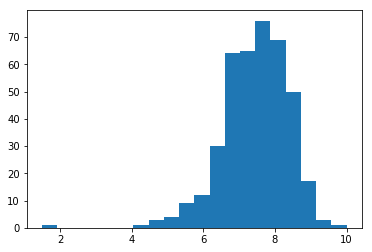

In [443]:
print df.rating.mean(), df.rating.median(), df.rating.std()
plt.hist(df['rating'],bins=20);

Looking at the histogram of ratings, we have a relatively normal distribution around a mean of 7.4 and median of 7.5. One show has a rating of 1.5, which will be dropped because it is an outlier. 

In [444]:
df.drop(425,inplace=True)

In [475]:
df[df['average_episodes'].isnull()]

,cast,crew,episode_count,genre,name,network,premiere,rating,runtime,show_type,status,summary,tv_maze_id,webChannel,average_episodes,genre_string,cast_string,crew_string
12,[Nathan Fielder],[],"[None, None, None]",[],Nathan for You,Comedy Central,2013-02-28,7.1,30,Reality,Running,<p>Self-proclaimed business expert Nathan Fiel...,3136,Network,NaN,,Nathan Fielder,
24,"[Mads Mikkelsen, Hugh Dancy, Laurence Fishburn...","[Elisa Roth, Sara Colleton, Michael Rymer, Jim...","[None, None, None]","[Drama, Crime, Horror, Thriller]",Hannibal,NBC,2013-04-04,8.5,60,Scripted,Ended,<p>Criminal profiler Will Graham is tasked by ...,194,Network,NaN,"Drama,Crime,Horror,Thriller",Mads Mikkelsen|Hugh Dancy|Laurence Fishburne|C...,Elisa Roth|Sara Colleton|Michael Rymer|Jim Dan...
45,"[Zach Callison, Deedee Magno, Michaela Dietz, ...","[Ian Jones-Quartey, Rebecca Sugar]","[None, None, None, None, None]","[Action, Adventure, Children, Science-Fiction]",Steven Universe,Cartoon Network,2013-11-04,9.4,15,Animation,Running,"<p><b>Steven Universe</b>, from Adventure Time...",1615,Network,NaN,"Action,Adventure,Children,Science-Fiction",Zach Callison|Deedee Magno|Michaela Dietz|Estelle,Ian Jones-Quartey|Rebecca Sugar
51,"[Christopher Meloni, Rachael Harris, Tyler Fod...","[Danny Rose, Justin Halpern, Jeff Ingold, Bill...",[None],"[Comedy, Family]",Surviving Jack,FOX,2014-03-27,7.4,30,Scripted,Ended,"<p>Set in Southern California, in 1991, the se...",2478,Network,NaN,"Comedy,Family",Christopher Meloni|Rachael Harris|Tyler Foden|...,Danny Rose|Justin Halpern|Jeff Ingold|Bill Cal...
65,"[Judd Hirsch, Donnie Keshawarz, Joel David Moo...","[John Kretchmer, Chris Fedak, Sarah Nicole Jon...",[None],"[Drama, Crime, Supernatural]",Forever,ABC,2014-09-22,8.4,60,Scripted,Ended,"<p>Doctor Henry Morgan, New York City's star m...",46,Network,NaN,"Drama,Crime,Supernatural",Judd Hirsch|Donnie Keshawarz|Joel David Moore|...,John Kretchmer|Chris Fedak|Sarah Nicole Jones|...
86,"[Jonathan Groff, Frankie J. Alvarez, Lauren We...","[Jill Soloway, Ben Wasserstein, Michael Lannan...","[None, None]","[Drama, Romance]",Looking,HBO,2014-01-19,6.7,30,Scripted,Ended,<p><b>Looking</b> offers up the unfiltered exp...,140,Network,NaN,"Drama,Romance",Jonathan Groff|Frankie J. Alvarez|Lauren Weedm...,Jill Soloway|Ben Wasserstein|Michael Lannan|Jo...
87,"[Jim Jefferies, Dan Bakkedahl, DJ Qualls]","[Paul F. Bernard, Jim Jefferies, Rick Clevelan...","[None, None]",[Comedy],Legit,FXX,2013-01-17,6.9,30,Scripted,Ended,<p>This outrageous new comedy stars Australian...,2095,Network,NaN,Comedy,Jim Jefferies|Dan Bakkedahl|DJ Qualls,Paul F. Bernard|Jim Jefferies|Rick Cleveland|K...
101,"[Elliot Cowan, Tom Bateman, Tom Riley, James F...","[Corey Reed, Nellie Reed, Courtney B. Conte, K...","[None, None, None]","[Drama, Horror]",Da Vinci's Demons,Online,2013-04-12,8.1,60,Scripted,Ended,<p>In a world where thought and faith are cont...,197,Starz Play,NaN,"Drama,Horror",Elliot Cowan|Tom Bateman|Tom Riley|James Faulk...,Corey Reed|Nellie Reed|Courtney B. Conte|Kevin...
102,"[Eric Edelstein, Bobby Moynihan, Demetri Martin]",[],"[None, None, None]","[Comedy, Family]",We Bare Bears,Cartoon Network,2015-07-27,8.7,15,Animation,Running,<p><b>We Bare Bears</b> is about three brother...,2612,Network,NaN,"Comedy,Family",Eric Edelstein|Bobby Moynihan|Demetri Martin,
105,"[Lili Taylor, Michael Irby, Mackenzie Crook, M...","[Naren Shankar, Joe Henderson, Cheo Hodari Cok...",[None],"[Drama, Action, Crime, Science-Fiction]",Almost Human,FOX,2013-11-17,7.7,60,Scripted,Ended,<p><b>Almost Human</b> is an action-packed pol...,202,Network,NaN,"Drama,Action,Crime,Science-Fiction",Lili Taylor|Michael Irby|Mackenzie Crook|Micha...,Naren Shankar|Joe Henderson|Cheo Hodari Coker|...


In [474]:
missing_ep_count = df[df['average_episodes'].isnull()]['tv_maze_id'].values

In [485]:
episode_count3 = []
for i in missing_ep_count:
    episodes = requests.get('http://api.tvmaze.com/shows/{}/episodes'.format(i))
    try :
        episode_count3.append(len(json.loads(episodes.text)))
    except :
        episode_count3.append(None)

In [490]:
episode_count3[:5]

[24, 39, 131, 8, 22]

In [488]:
missing_ep_index = df[df['average_episodes'].isnull()]['tv_maze_id'].index

In [499]:
seasons = df[df['average_episodes'].isnull()]['episode_count'].map(lambda x: float(len(x)))

In [552]:
missing_ep_avg = episode_count3/seasons
pd.DataFrame({'missing_ep_avg':missing_ep_avg}).head()

,missing_ep_avg
12,8.0
24,13.0
45,26.2
51,8.0
65,22.0


In [557]:
for i, j in zip(missing_ep_avg.index,missing_ep_avg.values):
    df.loc[i,'average_episodes'] = round(j,0)

We now have average season length for every show. There next column I want to work with is the premiere date. The date itself is not particularly interesting, but year and month could be relevant to a show's success. 

In [565]:
df['premiere_month'] = df['premiere'].map(lambda x: x.month)
df['premiere_year'] = df['premiere'].map(lambda x: x.year)

There are 6 shows that didn't list a genre, with a little research we can fill these in accordingly. 

In [587]:
df.loc[12,'genre_string'] = 'Documentary,Comedy'
df.loc[267,'genre_string'] = 'Drama'
df.loc[286,'genre_string'] = 'Action,Crime,Thriller'
df.loc[309,'genre_string'] = 'Crime,Drama'
df.loc[369,'genre_string'] =  'Crime,Drama,Mystery'
df.loc[402,'genre_string'] = 'Comedy,News,Talk-Show'

In [588]:
df[df['genre_string'] == '']

,cast,crew,episode_count,genre,name,network,premiere,rating,runtime,show_type,status,summary,tv_maze_id,webChannel,average_episodes,genre_string,cast_string,crew_string,premiere_month,premiere_year


Of the 6 shows with no cast, most are news/documentary or reality show based. Therefore it mostly makes sense that they do not have a cast. I will still double check and fill in as needed. 

In [591]:
df.loc[358,'cast_string'] = 'Nick Kroll|Jon Daly|Jenny Slate|John Mulaney|Sarah Dampf'

There are 31 shows without information on its crew. This information proves too difficult to impute. Fortunately, the missing shows do not seems to show any pattern in rating, mimicking the distribution of overall ratings, so hopefully the missing information will not skew the results dramatically. 

count    31.000000
mean      7.477419
std       1.092615
min       5.200000
25%       6.800000
50%       7.600000
75%       8.150000
max      10.000000
Name: rating, dtype: float64


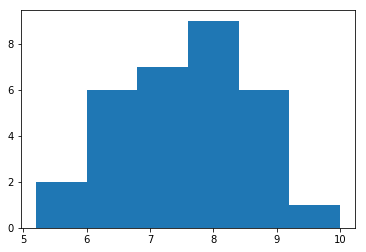

In [610]:
print df[df['crew_string'] == '']['rating'].describe()
plt.hist(df[df['crew_string'] == '']['rating'],bins=6);

With the data cleaned up, we can make decisions for modeling. I am going to set up a new dataframe with only the columns that may be features in a model. Removing the list versions of cast, crew, episodes_count, genre. Removing the full premiere date, status and tv_maze_id. Leaving name despite not likely being used just so it can be reference if needed. 

In [611]:
df.columns

Index([u'cast', u'crew', u'episode_count', u'genre', u'name', u'network',
       u'premiere', u'rating', u'runtime', u'show_type', u'status', u'summary',
       u'tv_maze_id', u'webChannel', u'average_episodes', u'genre_string',
       u'cast_string', u'crew_string', u'premiere_month', u'premiere_year'],
      dtype='object')

In [613]:
model_df = df.drop([u'cast', u'crew', u'episode_count', u'genre',u'premiere',u'status',u'tv_maze_id'],axis=1)

In [616]:
model_df.head()

,name,network,rating,runtime,show_type,summary,webChannel,average_episodes,genre_string,cast_string,crew_string,premiere_month,premiere_year
0,Rick and Morty,Adult Swim,9.4,30,Animation,"<p>Rick is a mentally gifted, but sociopathic ...",Network,10.0,"Comedy,Adventure,Science-Fiction",Justin Roiland|Spencer Grammer|Sarah Chalke|Ju...,Joe Russo II|Dan Guterman|Justin Roiland|Ryan ...,12,2013
1,True Detective,HBO,8.5,60,Scripted,<p>The series stars Matthew McConaughey and Wo...,Network,8.0,"Drama,Crime,Thriller,Mystery",Tory Kittles|Matthew McConaughey|Woody Harrels...,Matthew McConaughey|Jessica Levin|Nic Pizzolat...,1,2014
2,Last Week Tonight with John Oliver,HBO,9.2,30,Talk Show,<p>On <b>Last Week Tonight with John Oliver</b...,Network,30.0,Comedy,John Oliver,Tim Carvell|Jon Thoday,4,2014
3,Westworld,HBO,8.9,60,Scripted,<p>The one-hour drama series <b>Westworld</b> ...,Network,10.0,"Drama,Science-Fiction,Western",Anthony Hopkins|Jeffrey Wright|Thandie Newton|...,David Coatsworth|Katherine Lingenfelter|Robert...,10,2016
4,House of Cards,Online,8.7,60,Scripted,<p>Based on the BBC miniseries of the same nam...,Netflix,13.0,"Drama,Thriller",Kevin Spacey|Robin Wright|Michael Kelly|Derek ...,Johanna Argan|Karen Moore|Kirk Baxter|Aiman Hu...,2,2013


First we need to pick a target. Since our goal is to predict quality as defined by IMDB ratings, my initial target will be simply to predict if a show is above or below the median rating of 7.5. We are using a strictly greater than the median cutoff so we end up with 210 "bad" shows and 194 "good" shows. Therefore our baseline for future models will be approximately 52% accuracy. 

In [618]:
rating_median = model_df.rating.median()
rating_median

7.5

In [624]:
model_df['rating_binary'] = model_df['rating'].apply(lambda x: 1 if x > rating_median else 0)

In [625]:
model_df['rating_binary'].value_counts()

0    210
1    194
Name: rating_binary, dtype: int64

In [628]:
baseline = 210/404.
baseline

0.5198019801980198

In [631]:
model_df.columns

Index([u'name', u'network', u'rating', u'runtime', u'show_type', u'summary',
       u'webChannel', u'average_episodes', u'genre_string', u'cast_string',
       u'crew_string', u'premiere_month', u'premiere_year', u'rating_binary'],
      dtype='object')

In [1104]:
X = model_df[[u'network',u'runtime', u'show_type', u'summary',
       u'webChannel', u'average_episodes', u'genre_string', u'cast_string',
       u'crew_string', u'premiere_month']]
y = model_df['rating_binary']
X.head()

,network,runtime,show_type,summary,webChannel,average_episodes,genre_string,cast_string,crew_string,premiere_month
0,Adult Swim,30,Animation,"<p>Rick is a mentally gifted, but sociopathic ...",Network,10.0,"Comedy,Adventure,Science-Fiction",Justin Roiland|Spencer Grammer|Sarah Chalke|Ju...,Joe Russo II|Dan Guterman|Justin Roiland|Ryan ...,12
1,HBO,60,Scripted,<p>The series stars Matthew McConaughey and Wo...,Network,8.0,"Drama,Crime,Thriller,Mystery",Tory Kittles|Matthew McConaughey|Woody Harrels...,Matthew McConaughey|Jessica Levin|Nic Pizzolat...,1
2,HBO,30,Talk Show,<p>On <b>Last Week Tonight with John Oliver</b...,Network,30.0,Comedy,John Oliver,Tim Carvell|Jon Thoday,4
3,HBO,60,Scripted,<p>The one-hour drama series <b>Westworld</b> ...,Network,10.0,"Drama,Science-Fiction,Western",Anthony Hopkins|Jeffrey Wright|Thandie Newton|...,David Coatsworth|Katherine Lingenfelter|Robert...,10
4,Online,60,Scripted,<p>Based on the BBC miniseries of the same nam...,Netflix,13.0,"Drama,Thriller",Kevin Spacey|Robin Wright|Michael Kelly|Derek ...,Johanna Argan|Karen Moore|Kirk Baxter|Aiman Hu...,2


Create dummy variables out of the three categorical variables. 

In [1105]:
X_dummies = pd.get_dummies(X[['network','show_type','webChannel']]).drop(['network_Online','show_type_Scripted','webChannel_Network'],axis=1)

In [1106]:
X = pd.concat([X,X_dummies],axis=1).drop(['network','show_type','webChannel'],axis=1)

In [1107]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.25,random_state=42)
print Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

(303, 78) (101, 78) (303,) (101,)


Now that we have our train/test split, we need to process our text based variables. 

In [1304]:
cvec = CountVectorizer(binary=True, tokenizer=(lambda x: x.split('|')),min_df=2)

In [1305]:
Xtrain_cast = cvec.fit_transform(Xtrain['cast_string']).todense()
Xtrain_cast_cv = pd.DataFrame(Xtrain_cast,columns=cvec.get_feature_names(),index=Xtrain.index)

In [1307]:
Xtrain_crew = cvec.fit_transform(Xtrain['crew_string']).todense()
Xtrain_crew_cv = pd.DataFrame(Xtrain_crew,columns=cvec.get_feature_names(),index=Xtrain.index)

In [1297]:
cvec2 = CountVectorizer(binary=True, tokenizer=(lambda x: x.split(',')),min_df=10)

In [1298]:
Xtrain_genre = cvec2.fit_transform(Xtrain['genre_string']).todense()
Xtrain_genre_cv = pd.DataFrame(Xtrain_genre,columns=cvec2.get_feature_names(),index=Xtrain.index)

In [1299]:
cvec3 = CountVectorizer(stop_words='english',max_features=1000)

In [1300]:
Xtrain_summary = cvec3.fit_transform(Xtrain['summary']).todense()
Xtrain_summary_cv = pd.DataFrame(Xtrain_summary,columns=cvec3.get_feature_names(),index=Xtrain.index)

In [1301]:
Xtrain_final = pd.concat([Xtrain,Xtrain_cast_cv,Xtrain_crew_cv,Xtrain_genre_cv,Xtrain_summary_cv],axis=1).drop(['summary','genre_string','cast_string','crew_string'],axis=1)

Xtrain_final.shape

(303, 2073)

In [754]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [763]:
dt = DecisionTreeClassifier(class_weight='balanced')
bdt = BaggingClassifier(DecisionTreeClassifier())
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

def score(model, name):
    s = cross_val_score(model, Xtrain_final.values, ytrain.values, cv=cv)
    print("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

print round(baseline,4)
score(dt, "Decision Tree")
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")

0.5198
Decision Tree Score:	0.525 ± 0.029
Bagging DT Score:	0.554 ± 0.042
Random Forest Score:	0.538 ± 0.025
Extra Trees Score:	0.535 ± 0.008


In [761]:
from sklearn.model_selection import GridSearchCV


In [794]:
param_grid = {'max_depth':[10,20,30,40,50,60,70,80,90,None],'max_features':range(50,2060,50)}


In [796]:
optimalGrid = GridSearchCV(rf,param_grid=param_grid,cv=cv,verbose=1,n_jobs=-1)

In [797]:
optimalGrid.fit(Xtrain_final.values, ytrain.values)

Fitting 3 folds for each of 410 candidates, totalling 1230 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1230 out of 1230 | elapsed:  2.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [798]:
optimalGrid.best_score_

0.61056105610561051

In [799]:
optimalGrid.best_params_

{'max_depth': 20, 'max_features': 700}

In [816]:
logit = LogisticRegression(solver='liblinear')
param_grid2 = {'penalty': ['l1', 'l2'],'C': [0.01,0.1,1,10,100] }

In [817]:
optimalGrid2 = GridSearchCV(logit,param_grid=param_grid2,cv=cv,verbose=1,n_jobs=-1)

In [818]:
optimalGrid2.fit(Xtrain_final.values, ytrain.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [819]:
optimalGrid2.best_score_

0.55775577557755773

In [820]:
optimalGrid2.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [1302]:
cvec = CountVectorizer(binary=True, tokenizer=(lambda x: x.split('|')),min_df=2)

In [1306]:
Xtest_cast = cvec.transform(Xtest['cast_string']).todense()
Xtest_cast_cv = pd.DataFrame(Xtest_cast,columns=cvec.get_feature_names(),index=Xtest.index)

In [1308]:
Xtest_crew = cvec.transform(Xtest['crew_string']).todense()
Xtest_crew_cv = pd.DataFrame(Xtest_crew,columns=cvec.get_feature_names(),index=Xtest.index)

In [1280]:
cvec2 = CountVectorizer(binary=True, tokenizer=(lambda x: x.split(',')),min_df=10)

In [1309]:
Xtest_genre = cvec2.transform(Xtest['genre_string']).todense()
Xtest_genre_cv = pd.DataFrame(Xtest_genre,columns=cvec2.get_feature_names(),index=Xtest.index)

In [1282]:
cvec3 = CountVectorizer(stop_words='english',max_features=1000)

In [1310]:
Xtest_summary = cvec3.transform(Xtest['summary']).todense()
Xtest_summary_cv = pd.DataFrame(Xtest_summary,columns=cvec3.get_feature_names(),index=Xtest.index)

In [1311]:
Xtest_final = pd.concat([Xtest,Xtest_cast_cv,Xtest_crew_cv,Xtest_genre_cv,Xtest_summary_cv],axis=1).drop(['summary','genre_string','cast_string','crew_string'],axis=1)

Xtest_final.shape

(101, 2073)

In [1312]:
rf1 = RandomForestClassifier(max_depth= 20, max_features=700,class_weight='balanced', n_jobs=-1, n_estimators=20,random_state=42)

In [1313]:
rf1.fit(Xtrain_final.values, ytrain.values)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features=700,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [1314]:
rf1.score(Xtest_final.values,ytest.values)

0.51485148514851486

First run of models provided only marginal improvements over baseline. A gridsearched random forest resulted in the highest cv score (.611) with parameters of max depth of 20 and max features of 700. The optimal parameters of a Logistic Regression were a very small C of 0.01 with a Ridge penalty, though it only had a cv score of .558. 

To try and improve the model, I need to go back and change some of my NLP parameters. I tried different combinations for how to breakdown the cast and crew, specifically adjusting the threshold for minimum appearances. Similarly the threshold for genre, trying both all genres and the most frequent. For the summary, I tried limiting the number of features and up to 3 ngrams. Unfortunately, no combination stood out. Nearly every NLP combination resulted around 58%. 

After looking at feature importance, premiere year was heavily weighted. I was unsure about including it to begin with because you cannot really choose what year to premiere, so I drop the column to see the results. After removing year as a feature, the models barely performed over baseline. Notably cast and crew had no importance. Due to inconclusive result, I decided to try a new target. 

In [1113]:
cvec = CountVectorizer(binary=True, tokenizer=(lambda x: x.split('|')),min_df=2)

In [1114]:
Xtrain_cast = cvec.fit_transform(Xtrain['cast_string']).todense()
Xtrain_cast_cv = pd.DataFrame(Xtrain_cast,columns=cvec.get_feature_names(),index=Xtrain.index)

In [1115]:
Xtrain_crew = cvec.fit_transform(Xtrain['crew_string']).todense()
Xtrain_crew_cv = pd.DataFrame(Xtrain_crew,columns=cvec.get_feature_names(),index=Xtrain.index)

In [1127]:
cvec2 = CountVectorizer(binary=True, tokenizer=(lambda x: x.split(',')),min_df=10)

In [1128]:
Xtrain_genre = cvec2.fit_transform(Xtrain['genre_string']).todense()
Xtrain_genre_cv = pd.DataFrame(Xtrain_genre,columns=cvec2.get_feature_names(),index=Xtrain.index)

In [1176]:
cvec3 = CountVectorizer(stop_words='english')

In [1194]:
Xtrain_summary = cvec3.fit_transform(Xtrain['summary']).todense()
Xtrain_summary_cv = pd.DataFrame(Xtrain_summary,columns=cvec3.get_feature_names(),index=Xtrain.index)

In [1150]:
Xtrain_final = pd.concat([Xtrain,Xtrain_genre_cv,Xtrain_summary_cv],axis=1).drop(['summary','genre_string','cast_string','crew_string'],axis=1)

Xtrain_final.shape

(303, 5556)

In [1139]:
param_grid = {'min_samples_leaf':[10,15,20,25,30,40,50],'max_features':[None,.2,.3,.4,.5,.6,.7,.8,.9]}


In [1151]:
optimalGrid = GridSearchCV(rf,param_grid=param_grid,cv=cv,verbose=1)

In [1152]:
optimalGrid.fit(Xtrain_final.values, ytrain.values)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  1.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'min_samples_leaf': [10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [1153]:
optimalGrid.best_score_

0.5544554455445545

In [1154]:
optimalGrid.best_params_

{'max_features': 0.3, 'min_samples_leaf': 10}

In [1155]:
rf_final = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=20,random_state=42,max_features=.3,min_samples_leaf=10)

In [1156]:
rf_final.fit(Xtrain_final.values, ytrain.values)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.3,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [1162]:
feature_importances = pd.DataFrame(rf_final.feature_importances_,
                                   index = Xtrain_final.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
premiere_month,0.130224
average_episodes,0.095445
runtime,0.056418
network_ABC,0.042902
real,0.037900
action,0.032238
series,0.032012
drama,0.031186
world,0.028962
wife,0.028452


Despite a lot of tuning and iterations of feature selection, I was unable to produce a model that scored high enough over the baseline in cross validation to apply to my test set. So I have decided to revisit my target. Initially I looked to predict a show below/above the median, but perhaps there is more distinction looking at elite shows. My new target is shows above the 75% quartile which represents 8.1 score and greater. 

In [1196]:
model_df['elite_shows'] = model_df['rating'].apply(lambda x: 1 if x > 8 else 0)

In [1197]:
model_df['elite_shows'].value_counts()

0    303
1    101
Name: elite_shows, dtype: int64

In [1198]:
baseline2 = 303/404.
baseline2

0.75

In [1201]:
y2 = model_df['elite_shows']

In [1202]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X,y2,test_size=.25,random_state=42,stratify=y2)
print Xtrain2.shape, Xtest2.shape, ytrain2.shape, ytest2.shape

(303, 78) (101, 78) (303,) (101,)


In [1203]:
cvec = CountVectorizer(binary=True, tokenizer=(lambda x: x.split('|')),min_df=2)

In [1204]:
Xtrain2_cast = cvec.fit_transform(Xtrain2['cast_string']).todense()
Xtrain2_cast_cv = pd.DataFrame(Xtrain2_cast,columns=cvec.get_feature_names(),index=Xtrain2.index)

In [1205]:
Xtrain2_crew = cvec.fit_transform(Xtrain2['crew_string']).todense()
Xtrain2_crew_cv = pd.DataFrame(Xtrain2_crew,columns=cvec.get_feature_names(),index=Xtrain2.index)

In [1206]:
cvec2 = CountVectorizer(binary=True, tokenizer=(lambda x: x.split(',')),min_df=10)

In [1207]:
Xtrain2_genre = cvec2.fit_transform(Xtrain2['genre_string']).todense()
Xtrain2_genre_cv = pd.DataFrame(Xtrain2_genre,columns=cvec2.get_feature_names(),index=Xtrain2.index)

In [1208]:
cvec3 = CountVectorizer(stop_words='english')

In [1257]:
Xtrain2_summary = cvec3.fit_transform(Xtrain2['summary']).todense()
Xtrain2_summary_cv = pd.DataFrame(Xtrain2_summary,columns=cvec3.get_feature_names(),index=Xtrain2.index)

In [1258]:
Xtrain2_final = pd.concat([Xtrain2,Xtrain2_cast_cv,Xtrain2_crew_cv,Xtrain2_genre_cv,Xtrain2_summary_cv],axis=1).drop(['summary','genre_string','cast_string','crew_string'],axis=1)

Xtrain2_final.shape

(303, 6497)

In [1240]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=20,random_state=42)

In [1241]:
param_grid = {'min_samples_leaf':[10,15,20,25,30,40,50],'max_features':[None,.2,.3,.4,.5,.6,.7,.8,.9]}


In [1242]:
optimalGrid = GridSearchCV(rf,param_grid=param_grid,cv=cv,verbose=1)

In [1243]:
optimalGrid.fit(Xtrain2_final.values, ytrain2.values)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  1.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'min_samples_leaf': [10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [1244]:
optimalGrid.best_score_

0.60726072607260728

In [1245]:
optimalGrid.best_params_

{'max_features': 0.5, 'min_samples_leaf': 40}

Unfortunately, increasing the quality threshold did not come close to improving the score. Ultimately, our data was not able to determine the criteria for a successful show. However we have been provided some guidance toward further research that can be done to hopefully better accomplish the task. 

Next steps/musings: 
    - Cast and crew seemingly had little impact on the feature importance. While this can't be conclusive for future models, we should focus elsewhere. 
    - Summary was slightly more prominent and the next steps for summary analysis might be to perform deeper NLP, such as stemming or lemmatization to look for underlying patterns. 
    - If you expand the scope to more years, time series analysis might prove useful to see changes or trends over time. 
    - Are there fundemental differences between network and online hosted shows? Would the model improve with a binary condition?
    - Lastly, IMDB rating is only one proxy of success, perhaps other metrics would prove easier to predict. 